> "Why are we limited to chunk-level relevance? Are we really at the mercy of how we chopped up the text?"

## From single vectors to hundreds of tiny spotlights

Most embedding models collapse an entire sentence (or longer document chunk) into **one** vector. That abstraction is perfect for ranking documents, yet it intentionally discards token-level nuance. 

_The good news_: those fine-grained token vectors are still hiding inside the model’s last hidden layer, we just rarely look at them. 

In this post we dust them off and treat every token as a tiny queryable unit. 

By taking a simple cosine-similarity between a user question and each token, we can paint a heatmap that lights up where the semantic match lives, even inside a 32 k-token context window.

We can then leverage this information to extract relevant text spans.

**This paves the way for a chunk-free RAG paradigm, one that retrieves only the most semantically relevant spans, not pre-defined chunks, guided entirely by the query’s content.**

### A running example you can meme-orise

To keep things concrete we’ll work with an odd corpus: a 2005 “SpongeBob SquarePants Laptop” user manual. It is publicly available, short enough to follow on screen while still making use of the lengthy context window. We will:

- Embed the entire PDF and a sample query with **Qwen3-0.6B-Instruct**.
- Compute per-token relevance and surface the results as color-graded heatmaps.
- Postprocess the relevance signal to extract text spans.
- Observe the results for other queries.
- Compare Qwen3 results with Jina v4 Embeddings (in its ColBERT flavor) and see how they fare.

All with cool animated illustrations to support the the process.

### What you will learn

- How dense embeddings include token-level information, and how to extract it.
- How to compute relevance scores for every token in a document, using a single matrix multiplication.
- How to visualize the results as a heatmap, and how to extract relevant text spans from the heatmap using a purpose-built algorithm.
- The drawbacks using this approach in a production setting (spoiler, its the massive storage requirements).
- How ColBERT embeddings, which offer token-level embeddings, could also be used for this task.

Let’s zoom in!

_If you wish to follow this with an interactive jupyter notebook, you may find it at [github.com/carlesonielfa/qwen3_span_extraction](https://github.com/carlesonielfa/qwen3_span_extraction)._


In [3]:
from IPython.display import HTML, display

html = f"""
<iframe src="player.html"
        style="width:100%; aspect-ratio:16/9; border:0;"
        loading="lazy"></iframe>
"""
display(HTML(html))

## The model

The Qwen3 family of **embedding** models have been released on July 2025 under Apache-2.0 license.

They come in three sizes (0.6B, 4B and 8B), and feature a decoder-only architecture, based on that of the Qwen3 LLMs.

They are now top of the leaderboards, blowing out of the water previous models, setting a new standard for the state of the art in text embedding models.

Let's load the 0.6B version!

In [4]:
import matplotlib.pyplot as plt
import plotly.io as pio
import torch
from transformers import AutoModel, AutoTokenizer
import os

# For rendering in vscode + quarto
pio.renderers.default = "plotly_mimetype+notebook"
# Disable tqdm to avoid unnecessary output in the notebook (used by some libraries)
os.environ["TQDM_DISABLE"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load the Qwen3 model and tokenizer
qwen3_model = (
    AutoModel.from_pretrained("Qwen/Qwen3-Embedding-0.6B", torch_dtype=torch.bfloat16)
    .eval()
    .to(DEVICE)
)
qwen3_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-Embedding-4B")
print("Qwen3 Embedding-0.6B model loaded successfully!")


Qwen3 Embedding-0.6B model loaded successfully!


## The document

As mentioned before, as an example, we will use the manual for a Spongebob laptop created by **vtech** circa 2009.

Here is a preview of the document so you can browse through it:

<iframe
  src="https://docs.google.com/viewer?url=https://www.vtechkids.com/assets/data/products/{F162CE37-57EC-4B6E-AFBE-D9DA9CFA098D}/manuals/80-102900-Sponge_Bob_Laptop.pdf&embedded=true"
  width="100%"
  height="600px"
></iframe>


### Converting the document to markdown

Using `pymupdf4llm` we can easily convert our lovely spongebob laptop manual to markdown and preview its first page.

We will also compute at which character position each page starts, so we can later display the page number in the plots

In [5]:
import itertools

import pymupdf4llm
import httpx
from IPython.display import display_markdown

url = "https://www.vtechkids.com/assets/data/products/%7BF162CE37-57EC-4B6E-AFBE-D9DA9CFA098D%7D/manuals/80-102900-Sponge_Bob_Laptop.pdf"
# Download the PDF file
response = httpx.get(url, follow_redirects=True)
response.raise_for_status()  # Ensure the request was successful

document = "spongebob_laptop_manual"
# Save the PDF file to the local filesystem
with open(f"assets/{document}.pdf", "wb") as f:
    f.write(response.content)

md_conversion = pymupdf4llm.to_markdown(f"assets/{document}.pdf", page_chunks=True)
text_per_page = [c["text"] for c in md_conversion]

# Compute the character at which each page starts
acc_chars_per_page = list(itertools.accumulate([len(text) for text in text_per_page]))

text = "".join(text_per_page)
# Add a quote to each line so its displayed as a blockquote
text_preview = "\n".join(f"> {line}" for line in text_per_page[0].splitlines())
display_markdown(text_preview, raw=True)

> ## User’s Manual
> # SpongeBob Laptop
> 
> 
> © 2009 Viacom International Inc.
> All Rights Reserved. Created by
> Stephen Hillenburg.
> 
> 
> Join in every day on Nick Jr.
> 
> www.nickjr.com
> 

## Generating the token-level embeddings

We will use the model to create our embeddings for the document and query. 

### How can we generate token-level embeddings from a model meant to generate "sentence"-level embeddings?

> By default, these embeddings models will generate a single vector of 2560 dimensions (matching the "hidden size" of the model) for each input text.

In embedding models the single embedding vector is generated through pooling the last hidden state, usually through averaging the embeddings for each of the tokens or by selecting the embedding of a special token.

In the case of the Qwen3 embeddings this is achieved by just selecting the embedding for the special token `<|endoftext|>`, which is inserted as the last token in the batch by the tokenization process.

During training the model learns to make the embedding of this special token represent the entire input text, and thus it can be used as a compact representation of the input.

However, we can choose to forgo this pooling step. By not applying this pooling, we will be generating a matrix of size `(tokenized_text_length, 1024)`, resulting in an embedding vector for each token.



In [6]:
# | echo: false

from IPython.display import HTML, display

display(
    HTML("""
<div class="cell-output cell-output-display video-container">
        <video src="https://storage.googleapis.com/onielfa.com/articles/qwen3-span-relevance/DecoderDiagram.mp4" autoplay loop muted controls width="100%">
        Your browser does not support the video tag.
        </video>
</div>
""")
)


### Generating the embeddings for the document

As we are going to embed our document as a single chunk, one might be worried about the contents being to lengthy and running up against the context window limits for the model.

However, for these Qwen3 embedding models, the context window is a staggering 32k tokens, which makes it likely that our whole document will fit, however let's make sure by looking at the size of our tokenized document.

At the same time we compute these embeddings, we will be extracting a text representation of each of the tokens and a mapping between token to text position. This is useful for plotting each token and to convert from tokens indices to text indices once we know which tokens are relevant.

In [7]:
import torch
import torch.nn.functional as F
from transformers import PreTrainedModel, PreTrainedTokenizer


@torch.inference_mode()
def embed_text_qwen(
    text: str,
    max_length: int = 32768,
    model: PreTrainedModel = qwen3_model,
    tokenizer: PreTrainedTokenizer = qwen3_tokenizer,
) -> tuple[list[str], torch.Tensor, torch.Tensor]:
    """
    Embed the given text using the Qwen3 model and tokenizer.
    Args:
        text (str): The text to embed.
    Returns:
        tuple: A tuple containing the offsets and the text embeddings.
                - offsets (torch.Tensor): The offsets of the tokens in the original text.
                - text_embeds (torch.Tensor): The embeddings of the text.
    """
    # Tokenize using the Qwen3 tokenizer
    # and return the offsets and the text embeddings
    # The offsets will be used to map the embeddings back to the original text
    tokenized = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        return_offsets_mapping=True,
    ).to(DEVICE)

    # Run the tokenized input through the Qwen3 model to get the embeddings
    # The output is a tensor of shape (1, sequence_length, embedding_dim)
    text_embeds = model(**tokenized).last_hidden_state.squeeze(0)

    # Normalize each of the vectors to unit length
    # For cosine similarity calculations
    text_embeds = F.normalize(text_embeds, p=2, dim=-1)

    # Return the splitted text tokens
    text_toks = [
        tokenizer.decode(token_id, skip_special_tokens=False)
        for token_id in tokenized["input_ids"].squeeze().tolist()
    ]
    return text_toks, tokenized["offset_mapping"].squeeze(), text_embeds.cpu()


def map_offsets_to_pages(
    offsets: torch.Tensor, acc_chars_per_page: list[int]
) -> list[int]:
    # Mapping of character offsets to tokens for later visualizations
    acc_tokens_per_page = []
    for chars_in_page in acc_chars_per_page:
        # Remove the last offset token (special token)
        # And only check the start_token in the offset
        is_in_page = (
            offsets[
                :-1,
                :1,
            ]
            <= chars_in_page
        )
        acc_tokens_per_page.append(is_in_page.sum().item())
    return acc_tokens_per_page


text_toks, offsets, text_embeds = embed_text_qwen(text)
print(f"Number of tokens: {len(offsets)}")
print(f"Document embedding shape: {tuple(text_embeds.shape)}")

assert text_embeds.shape[0] == offsets.shape[0], (
    "Text and offsets should have the same number of tokens"
)

# Map offsets to pages
acc_tokens_per_page = map_offsets_to_pages(offsets, acc_chars_per_page)


# Create inverse mapping from token to char
token_char_starts = {i: int(start) for i, (start, end) in enumerate(offsets)}
token_char_ends = {i: int(end) for i, (start, end) in enumerate(offsets)}
assert len(token_char_starts) == len(token_char_ends) == text_embeds.shape[0], (
    "Token to char mapping should be consistent"
)

Number of tokens: 3597
Document embedding shape: (3597, 1024)


We can see that the embedding process resulted in 3597 vectors, meaning we are well below the 32k token limit!

### Generating the embeddings for the query

For embedding the query, the *Qwen* team recommend using an instruction prompt such as 
```
Instruct: Given a web search query, retrieve relevant passages that answer the query
Query:{query}
```

They indicate that not using a prompt can drop performance from 1-5%.

Since in our case we aren't after the last bit of performance, we'll embed the query without prompt, for simplicity.

_Exploring how the relevance of the words change depending on the prompt might be an interesting thing to do in the future._

The query we are going to use is:
```What game makes me reason by weighting objects?```

The response to this query is in page 9 of the document, and the game in question is called "Weighty Food".

In [8]:
query = "What game makes me reason by weighting objects?"
query_text_toks, _, query_embeds = embed_text_qwen(query)
print(f"Query text tokens: {query_text_toks}")
assert query_embeds.shape[0] == len(query_text_toks), (
    "Query tokens and colbert vector should have the same number of tokens"
)
print(f"Number of query tokens: {len(query_text_toks)}")
print(f"Query embedding shape: {tuple(query_embeds.shape)}")

Query text tokens: ['What', ' game', ' makes', ' me', ' reason', ' by', ' weighting', ' objects', '?', '<|endoftext|>']
Number of query tokens: 10
Query embedding shape: (10, 1024)


## How we score every token: from cosine similarity to one big matrix

When comparing **sentence** embeddings, we usually use **cosine similarity** to measure how close they are:

$$
\operatorname{cos\_sim}(\mathbf u, \mathbf v)
=
\frac{\mathbf u^{\top}\mathbf v}{\lVert\mathbf u\rVert_2 \lVert\mathbf v\rVert_2}
$$

For **token** embeddings, we do the same ,  but we normalize every token vector so its length is 1. This means:

$$
\lVert\mathbf u\rVert_2 = \lVert\mathbf v\rVert_2 = 1
$$

so cosine similarity simplifies to a dot product:

$$
\operatorname{cos\_sim}(\mathbf u,\mathbf v) = \mathbf u^{\top}\mathbf v.
$$


### Computing many token similarities in one matrix multiply

Define:

* $Q \in \mathbb{R}^{m \times d}$: the **query** token vectors as *rows*
* $D \in \mathbb{R}^{n \times d}$: the **document** token vectors as *rows*

Then a single matrix multiplication gives all token-to-token similarities:

$$
\boxed{
  R = Q\, D^\top
}
\quad\Longrightarrow\quad
R_{ij} = \mathbf q_i^{\top} \mathbf d_j \in [-1, 1].
$$

**Key points:**

* $R$ has shape $m \times n$: each row corresponds to a query token, each column to a document token
* values are between $-1$ and $1$ because all token vectors are unit-normalized
* modern frameworks (like `torch.matmul`) can compute these millions of dot products in a single call, making it extremely fast even for long contexts

All downstream logic starts from this single compact matrix $R$.

In [9]:
relevances = query_embeds @ text_embeds.T
relevances = relevances.to(torch.float32)
print(f"Relevance matrix shape: {list(relevances.shape)}")

Relevance matrix shape: [10, 3597]


### Visualizing the Relevance Matrix

To get some insight into the relationships of relevance between the query and document tokens, let's display an interactive heatmap where we can observe the values of the relevance matrix. 

In [10]:
# | column: page-inset
import numpy as np
import plotly.express as px
from IPython.display import HTML, display


def create_heatmap(relevances, query_text_toks, text_toks, acc_tokens_per_page):
    n_rows, n_cols = relevances.shape

    # Display heatmap
    fig = px.imshow(
        relevances,
        labels=dict(color="Relevance"),
        x=list(range(n_cols)),  # numeric x-coords → we’ll override ticks later
        y=query_text_toks,
        color_continuous_scale="Agsunset",
        aspect="auto",
    )

    # Show tokens on hover
    customdata = np.tile(text_toks, (n_rows, 1))  # duplicate token list down the rows

    fig.update_traces(
        customdata=customdata,
        hovertemplate=(
            "Query token: %{y}<br>"
            "Doc token  : %{customdata}<br>"
            "Relevance  : %{z:.3f}<extra></extra>"
        ),
    )
    # Show page numbers on the x-axis
    page_tick_positions = [0] + acc_tokens_per_page
    page_tick_texts = [f"Page {i + 1}" for i in range(len(page_tick_positions) - 1)] + [
        "<|endoftext|>"
    ]

    fig.update_xaxes(
        tickmode="array",
        tickvals=page_tick_positions,
        ticktext=page_tick_texts,
        tickangle=90,
        side="bottom",
    )
    return fig


def display_plot(fig):
    html = fig.to_html(full_html=False, include_plotlyjs="cdn")
    display(HTML(html))


fig = create_heatmap(
    relevances.to(torch.float32), query_text_toks, text_toks, acc_tokens_per_page
)
fig.update_layout(
    title="Heatmap for relevance between query and document tokens.", height=320
)

display_plot(fig)

### Collapsing to document token relevance over the whole query

We know that the Qwen3 embedding models are trained by taking the embedding for the `<|endoftext|>` token as the representative embedding for the whole text.

So the relevance score that we would see by using the embedding model with pooling **corresponds to the relevance value on the last row and last column of the relevance matrix**. Which is measuring the relevance between both of the `<|endoftext|>` tokens.

Using this information, if we wish to see the relevance of each document token to the whole query, is as easy as visualizing only the last row of this relevance matrix. As we would be comparing the relevance of the `<|endoftext|>` token (representative of the query) to each document token.

Knowing this, the relevance computation could have been simplified even further by just computing the relevance of the last row of the matrix, instead of computing the whole matrix.

$$
R_{\text{last}} = Q_\text{last} D^{\top}
$$

Focusing our attention on this plot, we can observe some patterns appearing, namely, hotspots with high relevance along the document.

In [11]:
# | column: page-inset
# | fig-cap: "Heatmap of token relevance between whole query and document tokens. Hover for details."

fig_collapsed = create_heatmap(
    relevances[-1:, :-1],  # Only the last row and remove the last column
    query_text_toks[-1:],  # Last query token
    text_toks[:-1],  # Last document token
    acc_tokens_per_page,
)
fig_collapsed.update_layout(
    title="Heatmap for relevance between query and document tokens (collapsed to last token).",
    height=240,
)
display_plot(fig_collapsed)

Let's now visualize it as a line plot to make it clearer.

In [13]:
# | column: page-inset
import pandas as pd


# Create a line plot for the last row of the heatmap
def create_line(relevances_vector, text_toks, acc_tokens_per_page):
    df = pd.DataFrame(
        relevances_vector,
        columns=["Raw relevance"],
    )
    # Display heatmap
    fig = px.line(df)

    # Show tokens on hover
    customdata = text_toks

    fig.update_traces(
        customdata=customdata,
        hovertemplate=(
            "Query token: %{y}<br>"
            "Doc token  : %{customdata}<br>"
            "Relevance  : %{y:.3f}<extra></extra>"
        ),
        line_color="gray",
    )
    if len(text_toks) > 1000:
        # Show page numbers on the x-axis
        page_tick_positions = [0] + acc_tokens_per_page
        page_tick_texts = [f"Page {i + 1}" for i in range(len(page_tick_positions) - 1)]

        fig.update_xaxes(
            tickmode="array",
            tickvals=page_tick_positions,
            ticktext=page_tick_texts,
            tickangle=90,
            side="bottom",
            title="Token index",
            showgrid=True,
        )
    else:
        fig.update_xaxes(
            title="Tokens",
            tickangle=90,
            tickvals=list(range(len(text_toks))),
            ticktext=text_toks,
            showgrid=True,
        )
    fig.update_yaxes(title="Relevance", showgrid=True)
    return fig


fig_line = create_line(
    relevances[-1, :-1],  # Only the last row and remove the last column
    text_toks[:-1],  # Last document token
    acc_tokens_per_page,
)
fig_line.update_layout(
    template="simple_white",
    title=f"Line plot for relevance between query <i>{query}</i> and document tokens.",
    showlegend=False,
    height=320,
)
display_plot(fig_line)

Much better!

We can now observe how the relevance is not uniform across the document, and that we have the strongest relevance in the middle of page 9, and along page 10, which matches the general area where the answer to our query is located.

## Finding relevant spans

Now, how can we extract relevant spans from this noisy data?

Looking at the raw data (you may hover over the line graph to see to which tokens correspond each of the scores), there seems to be a pattern in which the relevance will be higher at the end of relevant sentences rather than in specific relevant tokens.

It seems like the model may be combining and encoding the meaning of the previous tokens on those later tokens, which fits into the fact that the Qwen3 embedding models are based on a decoder-only architecture which does not use bidirectional attention like encoder based embedding models do.

This means that if we detect a high relevance token, it might be indicating that the tokens previous to that one are relevant as well.

Let's zoom into a specific sentence to showcase how high relevance appears at line endings such as  `\n` or `.`

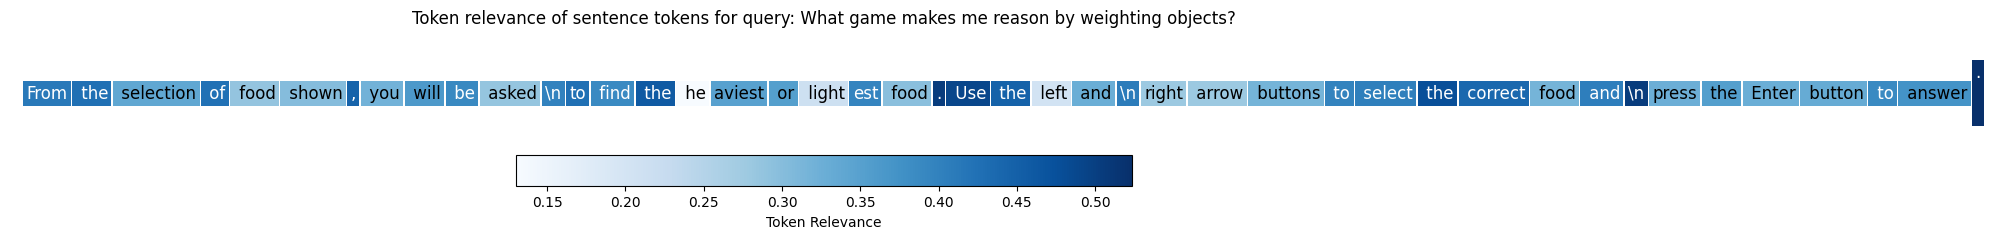

In [14]:
# | column: page-inset
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Example sentence indices (you may alter these to visualize different sentences)
sentence_idxs = (1717, 1761)

# Sample data
tokens = [
    a if a != "\n" else "\\n" for a in text_toks[sentence_idxs[0] : sentence_idxs[1]]
]
values = (
    relevances[-1, sentence_idxs[0] : sentence_idxs[1]].cpu().numpy()
)  # values between -1 and 1

# Normalize values to [0, 1]
norm = Normalize(vmin=min(values), vmax=max(values))
cmap = matplotlib.colormaps["Blues"]


def get_text_color(rgb):
    # rgb values are in [0,1]; calculate luminance
    r, g, b = rgb[:3]
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return "black" if luminance > 0.5 else "white"


fig, ax = plt.subplots(figsize=(21, 2))
ax.axis("off")

x = 0.01
y = 0.5
for word, val in zip(tokens, values, strict=False):
    bg_color = cmap(norm(val))
    text_color = get_text_color(bg_color)

    txt = ax.text(
        x,
        y,
        word,
        fontsize=12,
        va="center",
        ha="left",
        color=text_color,
        bbox=dict(facecolor=bg_color, edgecolor="none", boxstyle="square,pad=0.2"),
    )

    renderer = fig.canvas.get_renderer()
    bbox = txt.get_window_extent(renderer=renderer).transformed(ax.transData.inverted())
    x = bbox.x1 + 0.005

sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.2, pad=0)
cbar.set_label("Token Relevance")
plt.title("Token relevance of sentence tokens for query: " + query)
plt.show()

We now know that the peaks in the relevance signal are key, matching ends of relevance sentences and occasionally, exact text matches.

Let's devise an algorithm to extract these relevant spans. For that a naive implementation might follow something like this:

1. **Preprocess the relevance signal** (optional): 
    - I have found that using a smoothing filter such a gaussian filter makes the signal easier to work with for the next steps.
    - The adjustable parameter for this filter is `sigma`, which controls the amount of smoothing applied. A larger value will result in a smoother signal, while a smaller value will retain more of the original signal's peaks and troughs.
2. **Detect peaks**: Find tokens with relevance above a specific set `threshold`.
3. **Cluster nearby peaks**: Use a sliding window approach to cluster nearby peaks, the distance between peaks is controlled by a parameter `delta`.
4. **Filter out small spans** (optional): Remove spans that have less than `min_span_size` tokens. This steps aids in removing matches that may be purely based on a single token matching lexically.
5. **Extend the clusters**: Extend the match forwards and backwards until a separator is found to match a semantic unit, up to a maximum of `max_extension` tokens in each direction.
6. **Compute scores for each span**: This can be done via different aggregations of the relevance scores in the span. By using the maximum, we get a representative value that is invariant on how the cluster is extended.

In [15]:
# Now create a line plot of the smoothed token relevances
import re
import numpy as np
from scipy.ndimage import gaussian_filter1d

doc_relevances = relevances[-1, :-1].to(torch.float32)

# These could be expanded in the future.
SEPARATORS = ["\n", "\t", "."]
sep_re = re.compile("[" + re.escape("".join(SEPARATORS)) + "]")


def detect_spans(
    doc_relevances: torch.Tensor,
    doc_tokens: list[str],
    threshold: float,
    delta: int,
    min_span_size: int,
    max_extension: int = 32,
) -> tuple[list[tuple[int, int]], list[float]]:
    """
    Detects spans of relevance in the document relevances based on a threshold.

    Args:
        doc_relevances (torch.Tensor): The relevance scores for each token in the document.
        doc_tokens (list[str]): The tokens of the document.
        threshold (float): The threshold for relevance to consider a peak.
        delta (int): Maximum allowed gap between peaks to consider them in the same cluster.
        min_span_size (int): Minimum size of a span to be considered relevant.
        max_extension (int): Maximum number of tokens to extend the span to a separator in each direction.

    Returns:
        tuple: A tuple containing:
            - clustered_spans (list): A list of tuples representing the start and end indices of relevant spans.
            - scores (list): A list of scores for each clustered span, computed as the maximum relevance in the span.
    """
    peaks = torch.where(doc_relevances > threshold)[0].cpu().numpy()
    clustered_spans = []
    if peaks.size > 0:
        current_start = peaks[0]
        current_end = peaks[0]
        for idx in peaks[1:]:
            if idx <= current_end + delta:
                # same cluster: just move the end to this new peak
                current_end = idx
            else:
                # gap is too large -> finish current cluster, start a new one
                if current_end - current_start + 1 >= min_span_size:
                    clustered_spans.append((current_start, current_end))
                current_start = idx
                current_end = idx
        if current_end - current_start + 1 >= min_span_size:
            clustered_spans.append((current_start, current_end))

    if not clustered_spans:
        return [], []
    # Pre-compute a lookup for nearby separators
    tokens_arr = np.asarray(doc_tokens)
    is_sep = np.vectorize(lambda s: bool(sep_re.search(s)))(tokens_arr)

    last_seen = np.where(is_sep, np.arange(len(tokens_arr)), -1)
    prev_sep = np.maximum.accumulate(last_seen)

    next_seen = np.where(is_sep, np.arange(len(tokens_arr)), len(tokens_arr))
    next_sep = np.minimum.accumulate(next_seen[::-1])[::-1]

    # Extend left and right edge until the nearest separator
    extended = []
    for start, end in clustered_spans:
        lb = -1 if start == 0 else prev_sep[start - 1]
        rb = next_sep[end]
        new_start = max(lb + 1, start - max_extension)
        new_end = min(rb - 1, end + max_extension)
        if new_end >= new_start:
            extended.append((new_start, new_end))

    # Compute scores for the clustered spans (max relevance in the span)
    scores = [doc_relevances[start : end + 1].max().item() for start, end in extended]
    return extended, scores


def mask_from_spans(
    doc_relevances: torch.Tensor, clustered_spans: list[tuple[int, int]]
) -> torch.Tensor:
    """
    Create a mask from clustered spans.

    Args:
        doc_relevances (torch.Tensor): The relevance scores for each token in the document.
        clustered_spans (list): A list of tuples representing the start and end indices of relevant spans.

    Returns:
        torch.Tensor: A boolean mask indicating the positions of relevant spans.
    """
    mask = torch.zeros_like(doc_relevances, dtype=torch.bool)
    for start, end in clustered_spans:
        mask[start : end + 1] = True
    return mask


threshold = 0.39
# Smooth the token relevances using a Gaussian filter
smoothed_relevances = torch.Tensor(
    gaussian_filter1d(doc_relevances.numpy(), sigma=4, mode="nearest", order=0)
)
clustered_spans, scores = detect_spans(
    smoothed_relevances,
    text_toks[:-1],
    threshold=threshold,
    delta=170,
    min_span_size=15,
)
# Create mask for clustered spans
mask = mask_from_spans(smoothed_relevances, clustered_spans)


In [16]:
# | column: page-inset
import plotly.graph_objects as go


def plot_relevances_with_spans(
    fig: go.Figure,
    doc_relevances: torch.Tensor,
    smoothed_relevances: torch.Tensor | np.ndarray,
    mask: np.ndarray,
    threshold: float,
    acc_tokens_per_page: list[int],
    mask_gt: np.ndarray | None = None,
    row: int | None = None,
):
    """
    Plots the token relevances with shaded spans of relevance.
    Args:
        fig (go.Figure): The Plotly figure to add traces to.
        doc_relevances (torch.Tensor): The raw token relevances.
        smoothed_relevances (np.ndarray): The smoothed token relevances.
        mask (np.ndarray): A boolean mask indicating relevant spans.
        threshold (float): The threshold for relevance to consider a span.
        acc_tokens_per_page (list[int]): Cumulative token counts per page for x-axis ticks.
        row (int | None): The row number for subplotting. If None, plot in the first row.
    """
    kwargs = {"row": row, "col": 1} if row is not None else {}
    show_legend = row is None or row == 1
    x = np.arange(len(doc_relevances))
    y = doc_relevances.cpu().numpy()

    # Raw token-level relevances
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            name="Raw Relevance",
            mode="lines",
            line=dict(color="gray", width=1),
            opacity=0.5,
            showlegend=show_legend,
        ),
        **kwargs,
    )

    # Smoothed curve
    fig.add_trace(
        go.Scatter(
            x=x,
            y=smoothed_relevances,
            name="Smoothed Relevance",
            mode="lines",
            line=dict(color="gray", width=2),  # full opacity
            showlegend=show_legend,
        ),
        **kwargs,
    )

    def shade_span(ma: np.ndarray, opacity: float = 0.5, color: str = "salmon"):
        # Shade contiguous “relevant” spans exactly where mask==True
        in_span, start = False, 0
        for i, m in enumerate(ma):
            if m and not in_span:  # span starts
                in_span, start = True, i
            elif not m and in_span:  # span ends
                in_span = False
                fig.add_vrect(
                    x0=start - 0.5,
                    x1=i - 0.5,
                    fillcolor=color,
                    opacity=opacity,
                    layer="below",
                    line_width=0,
                    **kwargs,
                )
        # If the document ends inside a span
        if in_span:
            fig.add_vrect(
                x0=start - 0.5,
                x1=len(y) - 0.85,
                fillcolor=color,
                opacity=opacity,
                layer="below",
                line_width=0,
                **kwargs,
            )
            in_span, start = False, 0

    if mask_gt is not None:
        shade_span(mask_gt, opacity=0.85, color="lightskyblue")
    shade_span(mask)

    # Horizontal threshold line
    fig.add_hline(
        y=threshold,
        line=dict(color="red", dash="dash"),
        opacity=0.5,
        annotation_text="Relevance threshold",
        annotation_position="bottom right",
        **kwargs,
    )

    # Axis styling, page tick labels, grid, legend, size, theme
    tick_vals = [0] + acc_tokens_per_page
    tick_text = [f"Page {i + 1}" for i in range(len(tick_vals))]

    fig.update_xaxes(
        title_text="Token index",
        tickmode="array",
        tickvals=tick_vals,
        ticktext=tick_text,
        tickangle=90,
        showgrid=True,
        **kwargs,
    )
    fig.update_yaxes(title_text="Relevance score", showgrid=True, **kwargs)

    fig.update_layout(
        title="Token relevances and ground truth spans",
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
        margin=dict(l=40, r=40, t=70, b=40),
        autosize=True,
    )

    # Manually add legend for the spans and threshold line
    if show_legend:
        if mask_gt is not None:
            fig.add_trace(
                go.Scatter(
                    x=[None],  # No x data, just for legend
                    y=[None],  # No y data, just for legend
                    mode="lines",
                    line=dict(color="lightskyblue", width=2),
                    name="Ground truth spans",
                    showlegend=True,
                )
            )
        fig.add_trace(
            go.Scatter(
                x=[None],  # No x data, just for legend
                y=[None],  # No y data, just for legend
                mode="lines",
                line=dict(color="salmon", width=2),
                name="Relevant Spans",
                showlegend=True,
            )
        )
        fig.add_trace(
            go.Scatter(
                x=[None],  # No x data, just for legend
                y=[None],  # No y data, just for legend
                mode="lines",
                line=dict(color="red", dash="dash"),
                name="Relevance Threshold",
                showlegend=True,
            )
        )


fig_spans = go.Figure()
plot_relevances_with_spans(
    fig_spans,
    doc_relevances,
    smoothed_relevances,
    mask,
    threshold,
    acc_tokens_per_page,
)
fig_spans.update_layout(
    height=320,
)
display_plot(fig_spans)

In [17]:
import markdown
from IPython.display import display_html, display_markdown


def display_text_from_results(
    query: str,
    clustered_spans: list[tuple[int, int]],
    scores: list[float],
    top_k: int = 2,
):
    """
    Display the text for each clustered span with its score.

    Args:
        query (str): The original query text.
        clustered_spans (list[tuple[int, int]]): List of tuples representing the start and end indices of relevant spans.
        scores (list[float]): List of scores for each span.
        top_k (int): Number of top spans to display.
    """
    if not clustered_spans or not scores:
        display_markdown("No relevant spans found.", raw=True)
        return
    # Convert spans to text
    texts = [
        text[token_char_starts[start] : token_char_ends[end]]
        for start, end in clustered_spans
    ]
    # Sort spans by score
    sorted_spans = sorted(zip(texts, scores), key=lambda x: x[1], reverse=True)
    # Limit to top_k spans
    sorted_spans = sorted_spans[:top_k]
    display_markdown(f"### Top {top_k} spans for query: `{query}`", raw=True)
    results = ""
    for i, (txt, score) in enumerate(sorted_spans):
        # Add quote to the text for better formatting
        txt = "\n".join(f"\t {line}" for line in txt.splitlines())
        t = f"**Text for span {i + 1} - Score {score:.2f}**\n\n{txt}\n"
        results += t

    # Display as a collapsable section
    html = f"""
    <details>
        <summary>Click to view results</summary>
        <pre>{markdown.markdown(results)}</pre>
    </details>
    """
    display_html(html, raw=True)


# Display the text for the clustered spans
display_text_from_results(query, clustered_spans, scores, top_k=2)

### Top 2 spans for query: `What game makes me reason by weighting objects?`

Click to view results 
 Text for span 1 - Score 0.45 
 ### 7

 3) Word Scramble

 Help SpongeBob sort out the condiment bottles.
 A word is given, then it will be scrambled up. Help
 SpongeBob unscramble the word by placing the
 bottles in order. Use the left and right arrow buttons
 to select a bottle and press the Enter button. Then,
 choose a second bottle to swap it with. Repeat until
 the word is spelled out correctly.

 MATH

 There are three activities in this category. They teach counting, addition,
 subtraction, and the concept of weight.

 4) Weighty Food

 There are two scales weighing three different foods.
 From the selection of food shown, you will be asked
 to find the heaviest or lightest food. Use the left and
 right arrow buttons to select the correct food and
 press the Enter button to answer.

 5) Add Seasoning

 Help SpongeBob add seasoning to the Krabby
 Patty. A formula is shown, along with five
 condiments. Each condiment displays a different
 number. Select two condiments that will make
 the formula work. Use the left and right buttons to
 select the condiments and press the Enter button
 to confirm. You can also press a number button to answer.

 6) Boating Bubble

 Help Patrick drive safely to pick up the Krabby Patty
 buns. On the way, Patrick will encounter bubbles
 with different numbers. You will be asked to count in
 multiples of a certain number to help Patrick along
 his way. Steer with the up and down arrow buttons
 and catch the correct bubbles as you go.

 ### 8

 LOGIC

 There are three activities in this category. They teach memory, logic,
 and patterns.

 7) Assembling Patties

 There are three Krabby Patties on the grill, and each
 one has a different pattern. Help SpongeBob keep
 track of the Krabby Patty with the given pattern.
 Watch carefully as SpongeBob flips the Patties over
 and swaps their places. Then, use the left and right
 arrow buttons to select the correct Krabby Patty and
 press the Enter button to answer.

 8) Jellyfishing

 There are eight jellyfish on the screen and only two
 of them look exactly the same. Watch carefully and
 catch the two jellyfish that match each other. Use
 the arrow buttons to select and press the Enter
 button to confirm.

 9) Patty Catch

 SpongeBob bumped into the shelf and all the
 ingredients are falling down! Help SpongeBob
 make some Krabby Patties with the falling
 ingredients by following the model on the side of
 the screen. Use the left and right arrow buttons to
 catch the correct ingredients, and use the down
 arrow button to make the ingredients fall faster.

 ### 9

 CREATIVITY AND GAMES

 There are three activities in this category
 
 Text for span 2 - Score 0.42 
 Press a number button to hear the number, or use these buttons to answer
 questions in the Math category.

 **7. Arrow Buttons**

 Press these buttons to make a selection or answer
 a question

## Running it for multiple queries

Let's now visualize the output for different queries and compare it to the ground truth spans where the answer is located, showcasing how the algorithm behaves with different relevance signals

In [18]:
# | collapse: true
queries = [
    "What game makes me reason by weighting objects?",  # Middle of page 9
    "The display is too bright, what can I do?",  # Middle of page 7
    "What type of battery does the laptop use?",  # Second half of page 4
    "The laptop is not starting, what can I do?",  # End of page 12
]
gt_spans = [
    (1676, 1761),
    (1133, 1163),
    (655, 698),
    (2645, 2734),
]
gt_masks = [np.zeros_like(doc_relevances, dtype=bool) for _ in queries]
for (start, end), m in zip(gt_spans, gt_masks):
    m[start : end + 1] = True

for query, gt_span in zip(queries, gt_spans):
    print(f"Query: {query}")
    gt_text = "".join(text_toks[gt_span[0] : gt_span[1]])
    # Quote each line for better formatting
    gt_text = "\n".join(f"> {line}" for line in gt_text.splitlines())
    html = f"""
    <details>
        <summary>Click to view ground truth span</summary>
        <pre>{markdown.markdown(gt_text)}</pre>
    </details>
    """
    display_html(html, raw=True)

Query: What game makes me reason by weighting objects?


Click to view ground truth span 
 
 MATH 
 There are three activities in this category. They teach counting, addition,
subtraction, and the concept of weight. 
 4) Weighty Food 
 There are two scales weighing three different foods.
From the selection of food shown, you will be asked
to find the heaviest or lightest food. Use the left and
right arrow buttons to select the correct food and
press the Enter button to answer.

Query: The display is too bright, what can I do?


Click to view ground truth span 
 
 
 Contrast Slider 
 
 Slide this to the right to darken the screen contrast, or slide to the left to
make the screen contrast lighter.

Query: What type of battery does the laptop use?


Click to view ground truth span 
 
 three new “AA” (AM-3/LR6) 
 batteries into the compartment as
illustrated. (The use of new, alkaline
batteries is recommended for
maximum performance.)

Query: The laptop is not starting, what can I do?


Click to view ground truth span 
 
 
 
 If your VTech [®] SpongeBob Laptop stops working or does not turn on: 
 
 
 Check your batteries. Make sure the batteries are fresh and
properly installed. 
 
 
 If you are still having problems, visit our website at
www.vtechkids.com for troubleshooting tips. 
 
 
 If nothing happens when you press the On/Off button: 
 
 
 Check to see that the batteries are aligned correctly.

In [19]:
# | column: page-inset
from plotly.subplots import make_subplots


def process_query(fig, query, gt_mask, row):
    query_text_toks, _, query_embeds = embed_text_qwen(query)
    relevances = query_embeds @ text_embeds.T
    doc_relevances = relevances[-1, :-1].to(
        torch.float32
    )  # Only the last row and remove the last column
    smoothed_relevances = gaussian_filter1d(
        doc_relevances.cpu().numpy(), sigma=4, mode="nearest", order=0
    )
    threshold = 0.39
    spans, scores = detect_spans(
        torch.tensor(smoothed_relevances),
        text_toks,
        threshold=threshold,
        delta=170,
        min_span_size=15,
    )
    mask = mask_from_spans(doc_relevances, spans)
    fig = plot_relevances_with_spans(
        fig,
        doc_relevances,
        smoothed_relevances,
        mask,
        threshold=threshold,
        acc_tokens_per_page=acc_tokens_per_page,
        mask_gt=gt_mask,
        row=row,
    )
    return spans, scores


# Create a figure with subplots for each query
fig_queries = make_subplots(
    rows=len(queries),
    cols=1,
    shared_xaxes=False,
    vertical_spacing=0.12,
    subplot_titles=[f"Query: {q}" for q in queries],
)
results_per_query = []
for i, (query, gt) in enumerate(zip(queries, gt_masks)):
    results_per_query.append(process_query(fig_queries, query, gt, row=i + 1))
fig_queries.update_layout(
    height=1024,
    title=dict(y=0.98),
    legend=dict(y=1.04),
    margin=dict(t=100),  # increase top margin if needed
)
display_plot(fig_queries)

In the graph above, we can see how
 1. The different queries match very different parts of the document
 2. They generally align with the ground truth spans.

Below, you can explore the most relevant text spans identified for each query.


In [20]:
# Lets see the most relevant span for each query
for i, (query, (text_spans, scores)) in enumerate(zip(queries, results_per_query)):
    # Print all spans and scores for the query
    display_text_from_results(query, text_spans, scores, top_k=3)


### Top 3 spans for query: `What game makes me reason by weighting objects?`

Click to view results 
 Text for span 1 - Score 0.45 
 ### 7

 3) Word Scramble

 Help SpongeBob sort out the condiment bottles.
 A word is given, then it will be scrambled up. Help
 SpongeBob unscramble the word by placing the
 bottles in order. Use the left and right arrow buttons
 to select a bottle and press the Enter button. Then,
 choose a second bottle to swap it with. Repeat until
 the word is spelled out correctly.

 MATH

 There are three activities in this category. They teach counting, addition,
 subtraction, and the concept of weight.

 4) Weighty Food

 There are two scales weighing three different foods.
 From the selection of food shown, you will be asked
 to find the heaviest or lightest food. Use the left and
 right arrow buttons to select the correct food and
 press the Enter button to answer.

 5) Add Seasoning

 Help SpongeBob add seasoning to the Krabby
 Patty. A formula is shown, along with five
 condiments. Each condiment displays a different
 number. Select two condiments that will make
 the formula work. Use the left and right buttons to
 select the condiments and press the Enter button
 to confirm. You can also press a number button to answer.

 6) Boating Bubble

 Help Patrick drive safely to pick up the Krabby Patty
 buns. On the way, Patrick will encounter bubbles
 with different numbers. You will be asked to count in
 multiples of a certain number to help Patrick along
 his way. Steer with the up and down arrow buttons
 and catch the correct bubbles as you go.

 ### 8

 LOGIC

 There are three activities in this category. They teach memory, logic,
 and patterns.

 7) Assembling Patties

 There are three Krabby Patties on the grill, and each
 one has a different pattern. Help SpongeBob keep
 track of the Krabby Patty with the given pattern.
 Watch carefully as SpongeBob flips the Patties over
 and swaps their places. Then, use the left and right
 arrow buttons to select the correct Krabby Patty and
 press the Enter button to answer.

 8) Jellyfishing

 There are eight jellyfish on the screen and only two
 of them look exactly the same. Watch carefully and
 catch the two jellyfish that match each other. Use
 the arrow buttons to select and press the Enter
 button to confirm.

 9) Patty Catch

 SpongeBob bumped into the shelf and all the
 ingredients are falling down! Help SpongeBob
 make some Krabby Patties with the falling
 ingredients by following the model on the side of
 the screen. Use the left and right arrow buttons to
 catch the correct ingredients, and use the down
 arrow button to make the ingredients fall faster.

 ### 9

 CREATIVITY AND GAMES

 There are three activities in this category
 
 Text for span 2 - Score 0.42 
 Press a number button to hear the number, or use these buttons to answer
 questions in the Math category.

 **7. Arrow Buttons**

 Press these buttons to make a selection or answer
 a question

### Top 3 spans for query: `The display is too bright, what can I do?`

Click to view results 
 Text for span 1 - Score 0.45 
 the volume.

 13. Contrast Slider

 Slide this to the right to darken the screen contrast, or slide to the left to
 make the screen contrast lighter

### Top 3 spans for query: `What type of battery does the laptop use?`

Click to view results 
 Text for span 1 - Score 0.45 
 ||||||
 ||||||



 4 Category 26 Letter
 Buttons Buttons


 10 Number
 Buttons


 4 Arrow
 Buttons


 Repeat

 Button

 O n/Off
 Button

 Enter
 Button

 Cursor Mouse
 with 4 Arrows

 ### 2

 ### INCLUDED IN THIS PACKAGE

 - One VTech [®] SpongeBob Laptop learning toy

 - One user’s manual
 WARNING: All packing materials, such as tape, plastic sheets,

 packaging locks, wire ties and tags are not part of this
 toy, and should be discarded for your child’s safety.

 Note: Please keep the user manual as it contains important
 information.

 Unlock the packaging locks:

 Rotate the packaging locks
 90 degrees counter-clockwise.

 Pull out the packaging locks.
 ### GETTING STARTED

 BATTERY INSTALLATION

 1. Make sure the unit is OFF.
 2. Locate the battery cover on the bottom

 of the unit.
 3. Open the battery cover.
 4. Install three new “AA” (AM-3/LR6)

 batteries into the compartment as
 illustrated. (The use of new, alkaline
 batteries is recommended for
 maximum performance.)
 5. Replace the battery cover.

 ### 3

 BATTERY NOTICE

 - Install batteries correctly observing the polarity (+, -) signs to avoid
 leakage.

 - Do not mix old and new batteries.

 - Do not mix batteries of different types: alkaline, standard (carbon-zinc)
 or rechargeable (nickel-cadmium).

 - Remove the batteries from the equipment when the unit will not be
 used for an extended period of time.

 - Always remove exhausted batteries from the equipment.

 - Do not dispose of batteries in fire.

 - Do not attempt to recharge ordinary batteries.

 - The supply terminals are not to be short-circuited.

 - Only batteries of the same and equivalent type as recommended
 are to be used.

 WE DO NOT RECOMMEND THE USE OF RECHARGEABLE BATTERIES.
 ### PRODUCT FEATURES

 1. On/Off Button

 To turn the unit on, press the On/Off button. Press the On/Off button
 again to turn the unit off.

 2. Category Buttons

 Press a category button to choose one of the four learning categories.

 3. Character Buttons

 Press a character button to play a mini-game featuring that character.

 ### 4

 4. Enter Button

 Press this button to enter a choice.

 5. Letter Buttons

 Press a letter button to hear the letter name, or use these buttons to
 answer questions in the Word Challenge category.

 6. Number Buttons

 Press a number button to hear the number, or use these buttons to answer
 questions in the Math category.

 **7. Arrow Buttons**

 Press these buttons to make a selection or answer
 a question.

 8. Repeat Button

 Press this button to hear the last instruction or question repeated.

 9. Answer Button

 Press this button to reveal the answer.

 ### 5

 10
 
 Text for span 2 - Score 0.42 
 - Check to see that the batteries are aligned correctly.

 ### 11

 3. If you cannot hear any sound:

 - Adjust the volume switch to adjust the sound level of the speaker.

 TECHNICAL SUPPORT

 If you have a problem that cannot be solved by using this manual,
 we encourage you to visit us online or contact our Consumer Services
 Department with any problems and/or suggestions that you might have.
 A support representative will be happy to assist you.
 Before requesting support, please be ready to provide or include the
 information below:

 - The name of your product or model number (the model number is
 typically located on the back or bottom of your product
 
 Text for span 3 - Score 0.41 
 Screen

 Slider


 Buttons

 Volume
 Slider

 Demo
 Button

 Esc
 Button

 Answer
 Button

 |or mouse, kids will experience excitement and independent p hey learn.|Col2|Col3|Col4|Col5|
 |---|---|---|---|---

### Top 3 spans for query: `The laptop is not starting, what can I do?`

Click to view results 
 Text for span 1 - Score 0.41 
 2. If nothing happens when you press the On/Off button:

 - Check to see that the batteries are aligned correctly.

 ### 11

 3. If you cannot hear any sound

## The drawbacks

> This looks amazing! When can I have this in my production RAG system?

Hold your horses! There are some important drawbacks to consider before rushing to production with this approach.

**The attention mechanism may be playing tricks on us.**

One interesting pattern that shows up repeatedly is the rise in relevance toward the end of the document across all queries, peaking right at the conclusion.

This is notable because, according to the idea that Qwen3’s unidirectional attention encodes the meaning of earlier tokens into later ones, the model seems to be capturing the document’s meaning in its final tokens. This aligns with how the model has been trained to handle the `<|endoftext|>` token, which appears at the end of each document.

However, **this behavior could limit the general effectiveness of this method** for identifying relevant spans. If the model consistently assigns higher relevance to the end of the document, it may skew the results.

To address this, the model would need to learn to encode relevance at the level of individual tokens rather than concentrating it at the end. This reflects a limitation in how the Qwen3 embedding models are currently trained.

In theory, models trained with more fine-grained supervision, like the **ColBERT** family, shouldn't have this issue. We'll explore that in the next section.


**The storage requirements are massive.**

For our small 12-page document we generated 3,597 vectors, one for each token in the document. If we had used a traditional chunking method with 1,000-token chunks, we would have ended up with just 4 chunks, resulting in only 4 vectors for the entire document. **That means we're generating roughly 900 times more vectors than with a traditional chunking approach.**

To put this in perspective using storage size (assuming float16 precision), we would store
$3597 \times 1024 \times 2 = 7362048$ bytes, or approximately **7.36 MB** for a single document. In contrast, the traditional approach would use
$4 \times 1024 \times 2 = 8192$ bytes, or just **8 KB**.

Techniques like quantization can help reduce vector size. However, it might be more effective to shift our attention to models specifically trained to output compact, token-level embeddings, such as the ones taking a **ColBERT** approach. Let’s see how they perform in the next section.

## Comparison to Late-Interaction Embedding Models (ColBERT)

Late-interaction models such as ColBERT are embedding models that represent queries and documents using token-level embeddings, and they score relevance using the MaxSim metric. These models seem well-suited for span-level matching, as they are designed to output a vector for each token.

Initially, I experimented with two popular ColBERT variants that support large contexts: `jina-colbert-v2` from Jina and `GTE-ModernColBERT-v1` from LightOn AI. The original `ColBERT` and `ColBERT v2.0` were not tested due to their limited context length.

These models produced **mixed results**, underperforming compared to the Qwen3 model when using the same methodology.

However, while writing this post, a new and more powerful embedding model was released: [Jina Embeddings v4](https://huggingface.co/jinaai/jina-embeddings-v4). This multimodal embedding model is built on the Qwen2.5 VL 3B architecture and has been trained to generate both a single vector for an entire text and individual vectors for each token.

This section explores the results of applying this model using the same approach described above.


*Loading the jina-colbert-v2 model*

In [21]:
# | output: false
import torch
from transformers import AutoModel

# Initialize the model
colbert_model = AutoModel.from_pretrained(
    "jinaai/jina-embeddings-v4", trust_remote_code=True, torch_dtype=torch.float16
)
colbert_model.to(DEVICE)
print("Jina Embeddings v4 model loaded successfully!")


You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Jina Embeddings v4 model loaded successfully!


Embedding the document and query with the `jina-colbert-v2`.

In [22]:
from typing import Any

import torch


@torch.inference_mode()
def embed_colbert(
    model: Any, text: str, is_query: bool
) -> tuple[list[str], torch.Tensor, torch.Tensor]:
    prompt_name = "query" if is_query else "passage"
    task = "retrieval"
    encode_kwargs = model._validate_encoding_params(
        truncate_dim=None, prompt_name=prompt_name
    )
    tokenized_outputs = model.processor(
        text=f"{encode_kwargs['prefix']}: {text}",
        return_tensors="pt",
        return_offsets_mapping=True,
    )
    text_toks = [
        model.processor.decode(token_id, skip_special_tokens=False)
        for token_id in tokenized_outputs["input_ids"].squeeze().tolist()
    ]
    # Encode using the model
    embeds = model.encode_text(
        text,
        return_multivector=True,
        return_numpy=True,
        prompt_name=prompt_name,
        task=task,
    )
    return text_toks, tokenized_outputs["offset_mapping"].squeeze(), embeds


doc_toks_col, doc_offsets_col, doc_embeds_col = embed_colbert(
    colbert_model, text, is_query=False
)
# Remove the prefix tokens
doc_toks_col = doc_toks_col[3:]
doc_offsets_col = doc_offsets_col[3:]
doc_embeds_col = doc_embeds_col[3:]
print(f"Number of tokens: {len(doc_offsets_col)}")
print(f"Document embedding shape: {tuple(doc_embeds_col.shape)}")
assert doc_embeds_col.shape[0] == doc_offsets_col.shape[0], (
    "Text and offsets should have the same number of tokens ",
    doc_embeds_col.shape,
    doc_offsets_col.shape,
)
query = "What game makes me rea by weighting objects?"
query_toks_col, _, query_embeds_col = embed_colbert(colbert_model, query, is_query=True)
print(f"Query text tokens: {query_toks_col}")
relevances_col = torch.Tensor(query_embeds_col @ doc_embeds_col.T)
print(f"Relevance matrix shape: {list(relevances_col.shape)}")

Encoding texts...: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Number of tokens: 3596
Document embedding shape: (3596, 128)


Encoding texts...: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]

Query text tokens: ['Query', ':', ' What', ' game', ' makes', ' me', ' re', 'a', ' by', ' weighting', ' objects', '?']
Relevance matrix shape: [12, 3596]


In [23]:
# | column: page-inset
acc_tokens_per_page_col = map_offsets_to_pages(doc_offsets_col, acc_chars_per_page)
fig = create_heatmap(
    relevances_col, query_toks_col, doc_toks_col, acc_tokens_per_page_col
)
fig.update_layout(
    title="Heatmap for relevance between query and document tokens using ColBERT.",
    height=670,
)
display_plot(fig)

Since we no longer have access to the `<|endoftext|>` token (which previously allowed us to extract a relevance score for the entire query), we need to aggregate token-level relevance scores into a single relevance score vector.

I compared three aggregation methods to achieve this:

* **Maximum**: Aggregating by taking the **maximum** token relevance aligns with the `MaxSim` metric commonly used in relevance computations for these models. It intuitively captures the strongest signal among the query tokens.

* **Mean**: Because the model uses [mean pooling to generate a single vector representing the entire text](https://huggingface.co/jinaai/jina-embeddings-v4#:~:text=Pooling%20Strategy-,Mean%20pooling,-Attention%20Mechanism), it makes sense to also try averaging the token relevance scores.

* **Single query vector**: This model is trained to produce a single embedding for an entire input. Using that vector to represent the query is conceptually similar to how the `<|endoftext|>` token is used in the Qwen3 model.

> Note: ColBERT produces 128-dimensional vectors, while the single-query vector is 2048-dimensional, making direct comparison infeasible. However, thanks to Matryoshka representation learning, which supports flexible embedding sizes, we can [**truncate the 2048-dimensional vector to 128 dimensions** with **minimal performance loss**](https://huggingface.co/jinaai/jina-embeddings-v4#:~:text=Flexible%20embedding%20size%3A%20dense%20embeddings%20are%202048%20dimensions%20by%20default%20but%20can%20be%20truncated%20to%20as%20low%20as%20128%20with%20minimal%20performance%20loss.)).

The resulting relevance signals from these methods are compared to the Qwen3 model’s signal in the following plot.

Additionally, we compute the **F1 Score** between the gold relevance span and the spans identified by each model and aggregation method.

> In this context, the F1 Score measures the overlap between the predicted and gold spans, combining precision (avoiding extra tokens) and recall (capturing all relevant tokens) into a single metric ranging from 0 to 1.


In [24]:
# | column: page-inset
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d


def compute_f1(
    mask: np.ndarray | torch.Tensor,
    mask_gt: np.ndarray | torch.Tensor,
) -> float:
    """Compute F1 score between two masks."""
    mask = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask
    mask_gt = mask_gt.cpu().numpy() if isinstance(mask_gt, torch.Tensor) else mask_gt
    intersection = np.logical_and(mask, mask_gt).sum()
    precision = intersection / mask.sum() if mask.sum() > 0 else 0.0
    recall = intersection / mask_gt.sum() if mask_gt.sum() > 0 else 0.0
    return (
        (2 * precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0.0
    )


doc_relevances_max_col = torch.amax(relevances_col, dim=0)

smoothed_relevances_max_col = torch.Tensor(
    gaussian_filter1d(
        doc_relevances_max_col.cpu().numpy(), sigma=4, mode="nearest", order=0
    )
)
doc_relevances_mean_col = torch.mean(relevances_col, dim=0)
smoothed_relevances_mean_col = torch.Tensor(
    gaussian_filter1d(
        doc_relevances_mean_col.cpu().numpy(), sigma=4, mode="nearest", order=0
    )
)
query_embeds_col_single_vector = colbert_model.encode_text(
    query,
    return_multivector=False,
    prompt_name="query",
    task="retrieval",
).cpu()
doc_relevances_single_col = query_embeds_col_single_vector[:128] @ doc_embeds_col.T
smoothed_relevances_single_col = torch.Tensor(
    gaussian_filter1d(
        doc_relevances_single_col.cpu().numpy(),
        sigma=4,
        mode="nearest",
        order=0,
    )
)


# Manually selected ground truth spans from the document
ground_truth_col = np.zeros_like(doc_relevances_max_col)
ground_truth_col[1679:1763] = 1

threshold = 0.39
delta = 170
min_span_size = 15

spans_max_col, scores_max_col = detect_spans(
    smoothed_relevances_max_col,
    doc_toks_col,
    threshold=threshold,
    delta=delta,
    min_span_size=min_span_size,
)
mask_max_col = mask_from_spans(doc_relevances_max_col, spans_max_col)

spans_mean_col, scores_mean_col = detect_spans(
    smoothed_relevances_mean_col,
    doc_toks_col,
    threshold=0.16,
    delta=delta,
    min_span_size=min_span_size,
)
mask_mean_col = mask_from_spans(doc_relevances_mean_col, spans_mean_col)

spans_single_col, scores_single_col = detect_spans(
    smoothed_relevances_single_col,
    doc_toks_col,
    threshold=0.02,
    delta=delta,
    min_span_size=min_span_size,
)
mask_single_col = mask_from_spans(doc_relevances_single_col, spans_single_col)


ground_truth_qwen3 = np.zeros_like(doc_relevances)
ground_truth_qwen3[1676:1760] = (
    1  # Ground truth span for Qwen3 (different tokenization)
)
fig = make_subplots(
    rows=4,
    cols=1,
    shared_xaxes=False,
    vertical_spacing=0.16,
    subplot_titles=[
        f"<b>Jina</b> Max pooling | F1 {compute_f1(mask_max_col, ground_truth_col):.2f} 👍",
        f"<b>Jina</b> Mean pooling | F1 {compute_f1(mask_mean_col, ground_truth_col):.2f} 👎",
        f"<b>Jina</b> Single vector for query | F1 {compute_f1(mask_single_col, ground_truth_col):.2f} 👎",
        f"<b>Qwen3</b> &lt;|endoftext|&gt; token pooling | F1 {compute_f1(mask, ground_truth_qwen3):.2f} 👍",
    ],
)
plot_relevances_with_spans(
    fig,
    doc_relevances_max_col,
    smoothed_relevances_max_col,
    mask_max_col,
    threshold,
    acc_tokens_per_page=acc_tokens_per_page_col,
    mask_gt=ground_truth_col,
    row=1,
)
plot_relevances_with_spans(
    fig,
    doc_relevances_mean_col,
    smoothed_relevances_mean_col,
    mask_mean_col,
    0.16,
    acc_tokens_per_page=acc_tokens_per_page_col,
    mask_gt=ground_truth_col,
    row=2,
)
plot_relevances_with_spans(
    fig,
    doc_relevances_single_col,
    smoothed_relevances_single_col,
    mask_single_col,
    0.02,
    acc_tokens_per_page=acc_tokens_per_page_col,
    mask_gt=ground_truth_col,
    row=3,
)
plot_relevances_with_spans(
    fig,
    doc_relevances,
    smoothed_relevances,
    mask,
    threshold,
    mask_gt=ground_truth_qwen3,
    acc_tokens_per_page=acc_tokens_per_page,
    row=4,
)
fig.update_layout(
    title="Token relevances comparing Jina Embeddings v4 (ColBERT) and Qwen3",
)
fig.update_layout(
    height=1024,
    title=dict(y=0.98),
    legend=dict(y=1.04),
    margin=dict(t=100),  # increase top margin if needed
)
display_plot(fig)

Encoding texts...: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]
/tmp/ipykernel_61663/36727548.py:42: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



In the comparison we can observe that the Jina model is able to display a nice relevance signal when using the maximum aggregation, with a peak at the ground truth span.

The F1 scores corroborate this, as we have a strong F1 score for both the maximum and last token pooling. And the one for Qwen3 is a fair bit lower, since it has lower precision.

This all looks promising, but let's check out the results for the other queries.

In [25]:
# | column: page-inset
from plotly.subplots import make_subplots


def process_query_col(fig, query, gt_mask, row):
    query_text_toks, _, query_embeds = embed_colbert(
        colbert_model, query, is_query=True
    )
    relevances = torch.Tensor(query_embeds @ doc_embeds_col.T)
    doc_relevances = torch.amax(relevances, dim=0)
    # doc_relevances = relevances[-1]
    smoothed_relevances = gaussian_filter1d(
        doc_relevances.cpu().numpy(), sigma=4, mode="nearest", order=0
    )
    threshold = 0.39
    spans, scores = detect_spans(
        torch.tensor(smoothed_relevances),
        doc_toks_col,
        threshold=threshold,
        delta=170,
        min_span_size=15,
    )
    mask = mask_from_spans(doc_relevances, spans)
    fig = plot_relevances_with_spans(
        fig,
        doc_relevances,
        smoothed_relevances,
        mask,
        threshold=threshold,
        acc_tokens_per_page=acc_tokens_per_page_col,
        mask_gt=gt_mask,
        row=row,
    )
    return spans, scores


# Create a figure with subplots for each query
fig_queries = make_subplots(
    rows=len(queries),
    cols=1,
    shared_xaxes=False,
    vertical_spacing=0.12,
    subplot_titles=[f"Query: {q}" for q in queries],
)
results_per_query = []
for i, (query, gt) in enumerate(zip(queries, gt_masks)):
    results_per_query.append(process_query_col(fig_queries, query, gt, row=i + 1))
fig_queries.update_layout(
    height=1024,
    title=dict(y=0.98),
    legend=dict(y=1.04),
    margin=dict(t=100),  # increase top margin if needed
)
fig.update_layout(
    title="Token relevances and ground truth spans for Jina Embeddings v4 (ColBERT) model.",
)
display_plot(fig_queries)

Encoding texts...: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


As shown in the graph, the relevance scores for the second query are noticeably lower than those for the others.

If this were a common issue, it would be a major drawback for using the model in production, since it would make it **hard to set a single threshold that works well across all queries**. Even if this is just a one-off case with this particular query, it still **shows there's room for improvement** in how this approach is applied to both this model and ColBERT models more generally.

That said, the **Jina Embeddings v4** model looks promising. It also solves the storage problem we saw with the Qwen3 model by using 128-dimensional token embeddings instead of 1024-dimensional ones. That makes it a more practical option for this kind of task.

This ends this article! For any questions or comments, feel free to comment on the related linked in post `TODO: Add link` or DM me directly at `linkedin.com/in/carlesonielfa`